# Adding your own custom high-fidelity solver

Advanced users may want to substitute the default solvers in `rose` for their own custom ones. This tutorial will walk through that process, with scattering of 14.1 MeV neutrons on $^{27}$Al, using the [Koning-Delaroche](https://www.sciencedirect.com/science/article/pii/S0375947402013210?casa_token=qS1v6U4xDQEAAAAA:NIi9D5LpP3f05AMwRnvbQ6or8hSvXoEIgKBV56KA4l9aObCOVDAndmuCeIH77iuzoXMOOlAMyw) optical potential for the proton-nucleus interaction. 

We will add [this solver](https://pypi.org/project/lagrange-rmatrix/), which uses the calculable R-matrix method on a Lagrange-Legendre mesh. In principle, this should provide a very precise solver, that is also capable of non-local and coupled-channels potentials. 

In [1]:
import rose
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import pickle
from tqdm import tqdm

In [2]:
from matplotlib import colormaps as cm
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator, StrMethodFormatter
from rose.training import multiple_formatter

colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

plt.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rcParams["text.latex.preamble"] = (
    r"\usepackage{amssymb} \usepackage{amsmath} \usepackage{braket}"
)
plt.rc("text", usetex=True)

rcParams["legend.fontsize"] = 12
rcParams["font.size"] = 12
rcParams["font.weight"] = "normal"
rcParams["xtick.labelsize"] = 12.0
rcParams["ytick.labelsize"] = 12.0
rcParams["lines.linewidth"] = 2.0
rcParams["xtick.major.pad"] = "10"
rcParams["ytick.major.pad"] = "10"
rcParams["image.cmap"] = "BuPu"

In [3]:
# !pip install jitr
import jitr
from numba import njit

In [4]:
# set up kinematics
from rose.koning_delaroche import KDGlobal, Projectile

# for 27-Al
A = 27
Z = 13

# lab bombarding energy
E_lab = 35  # MeV

# get kinematics and default KD params
mu, E_com, k, eta = rose.utility.kinematics((A,Z), (1,0), E_lab=E_lab)
omp = rose.koning_delaroche.KDGlobal(Projectile.neutron)
R_C, parameters = omp.get_params(A, Z, mu, E_com, k)

In [5]:
# take train and test parameter samples from a box bounded
# 50% above and below the default values
scale = 0.25

bounds = np.array(
    [
        parameters - np.fabs(scale * parameters),
        parameters + np.fabs(scale * parameters),
    ]
).T

In [6]:
from rose.training import sample_params_LHC

# sample points for a train/test split
# sample from +/-50% around the default params using Latin hypercube
n_train = 100
n_test = 100
training_samples = sample_params_LHC(n_train, parameters, scale, seed=13)
# grab some test parameters
test_samples = rose.training.sample_params_LHC(n_test, parameters, scale, seed=1233)

To use the `jitr` package as a custom solver in `rose`, we will need to use a derived class of `rose.SchroedingerEquation`: `LagrangeRmatrix`. This class is located in `src/rose/lagrangelegendersolver.py`, and can serve as a template example for interfacing external solvers in ROSE.

Let's set up the system:

In [7]:
nodes_within_radius = 3
s_0 = nodes_within_radius * (2 * np.pi) # channel matching radius

angles = np.linspace(1e-3, np.pi, 300)
s_mesh = np.linspace(1e-10, s_0, 1000)
domain = [s_mesh[0], s_0]

In [8]:
# create an interaction space for partial waves

interactions = rose.InteractionEIMSpace(
    coordinate_space_potential=rose.koning_delaroche.KD_simple,
    n_theta=len(parameters),
    mu=mu,
    energy=E_com,
    is_complex=True,
    spin_orbit_term=rose.koning_delaroche.KD_simple_so,
    training_info=bounds,
    Z_1=0,
    Z_2=13,
    R_C=R_C,
    l_max=20,
    expl_var_ratio_cutoff=1.0e-6,
    rho_mesh=s_mesh,
)

In [9]:
rk_domain = [domain[0], domain[1] + np.pi]  # extend rk domain past s_0
hifi_solver = rose.SchroedingerEquation.make_base_solver(
        rk_tols=[1e-10, 1e-10], s_0=s_0, domain=rk_domain
)

emu = rose.ScatteringAmplitudeEmulator.from_train(
    interactions,
    training_samples,
    base_solver=hifi_solver,
    n_basis=20,
    angles=angles,
    s_mesh=s_mesh,
    scale=True,
    use_svd=True,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [04:33<00:00, 13.05s/it]


/home/kyle/mambaforge/envs/om/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 8.0)

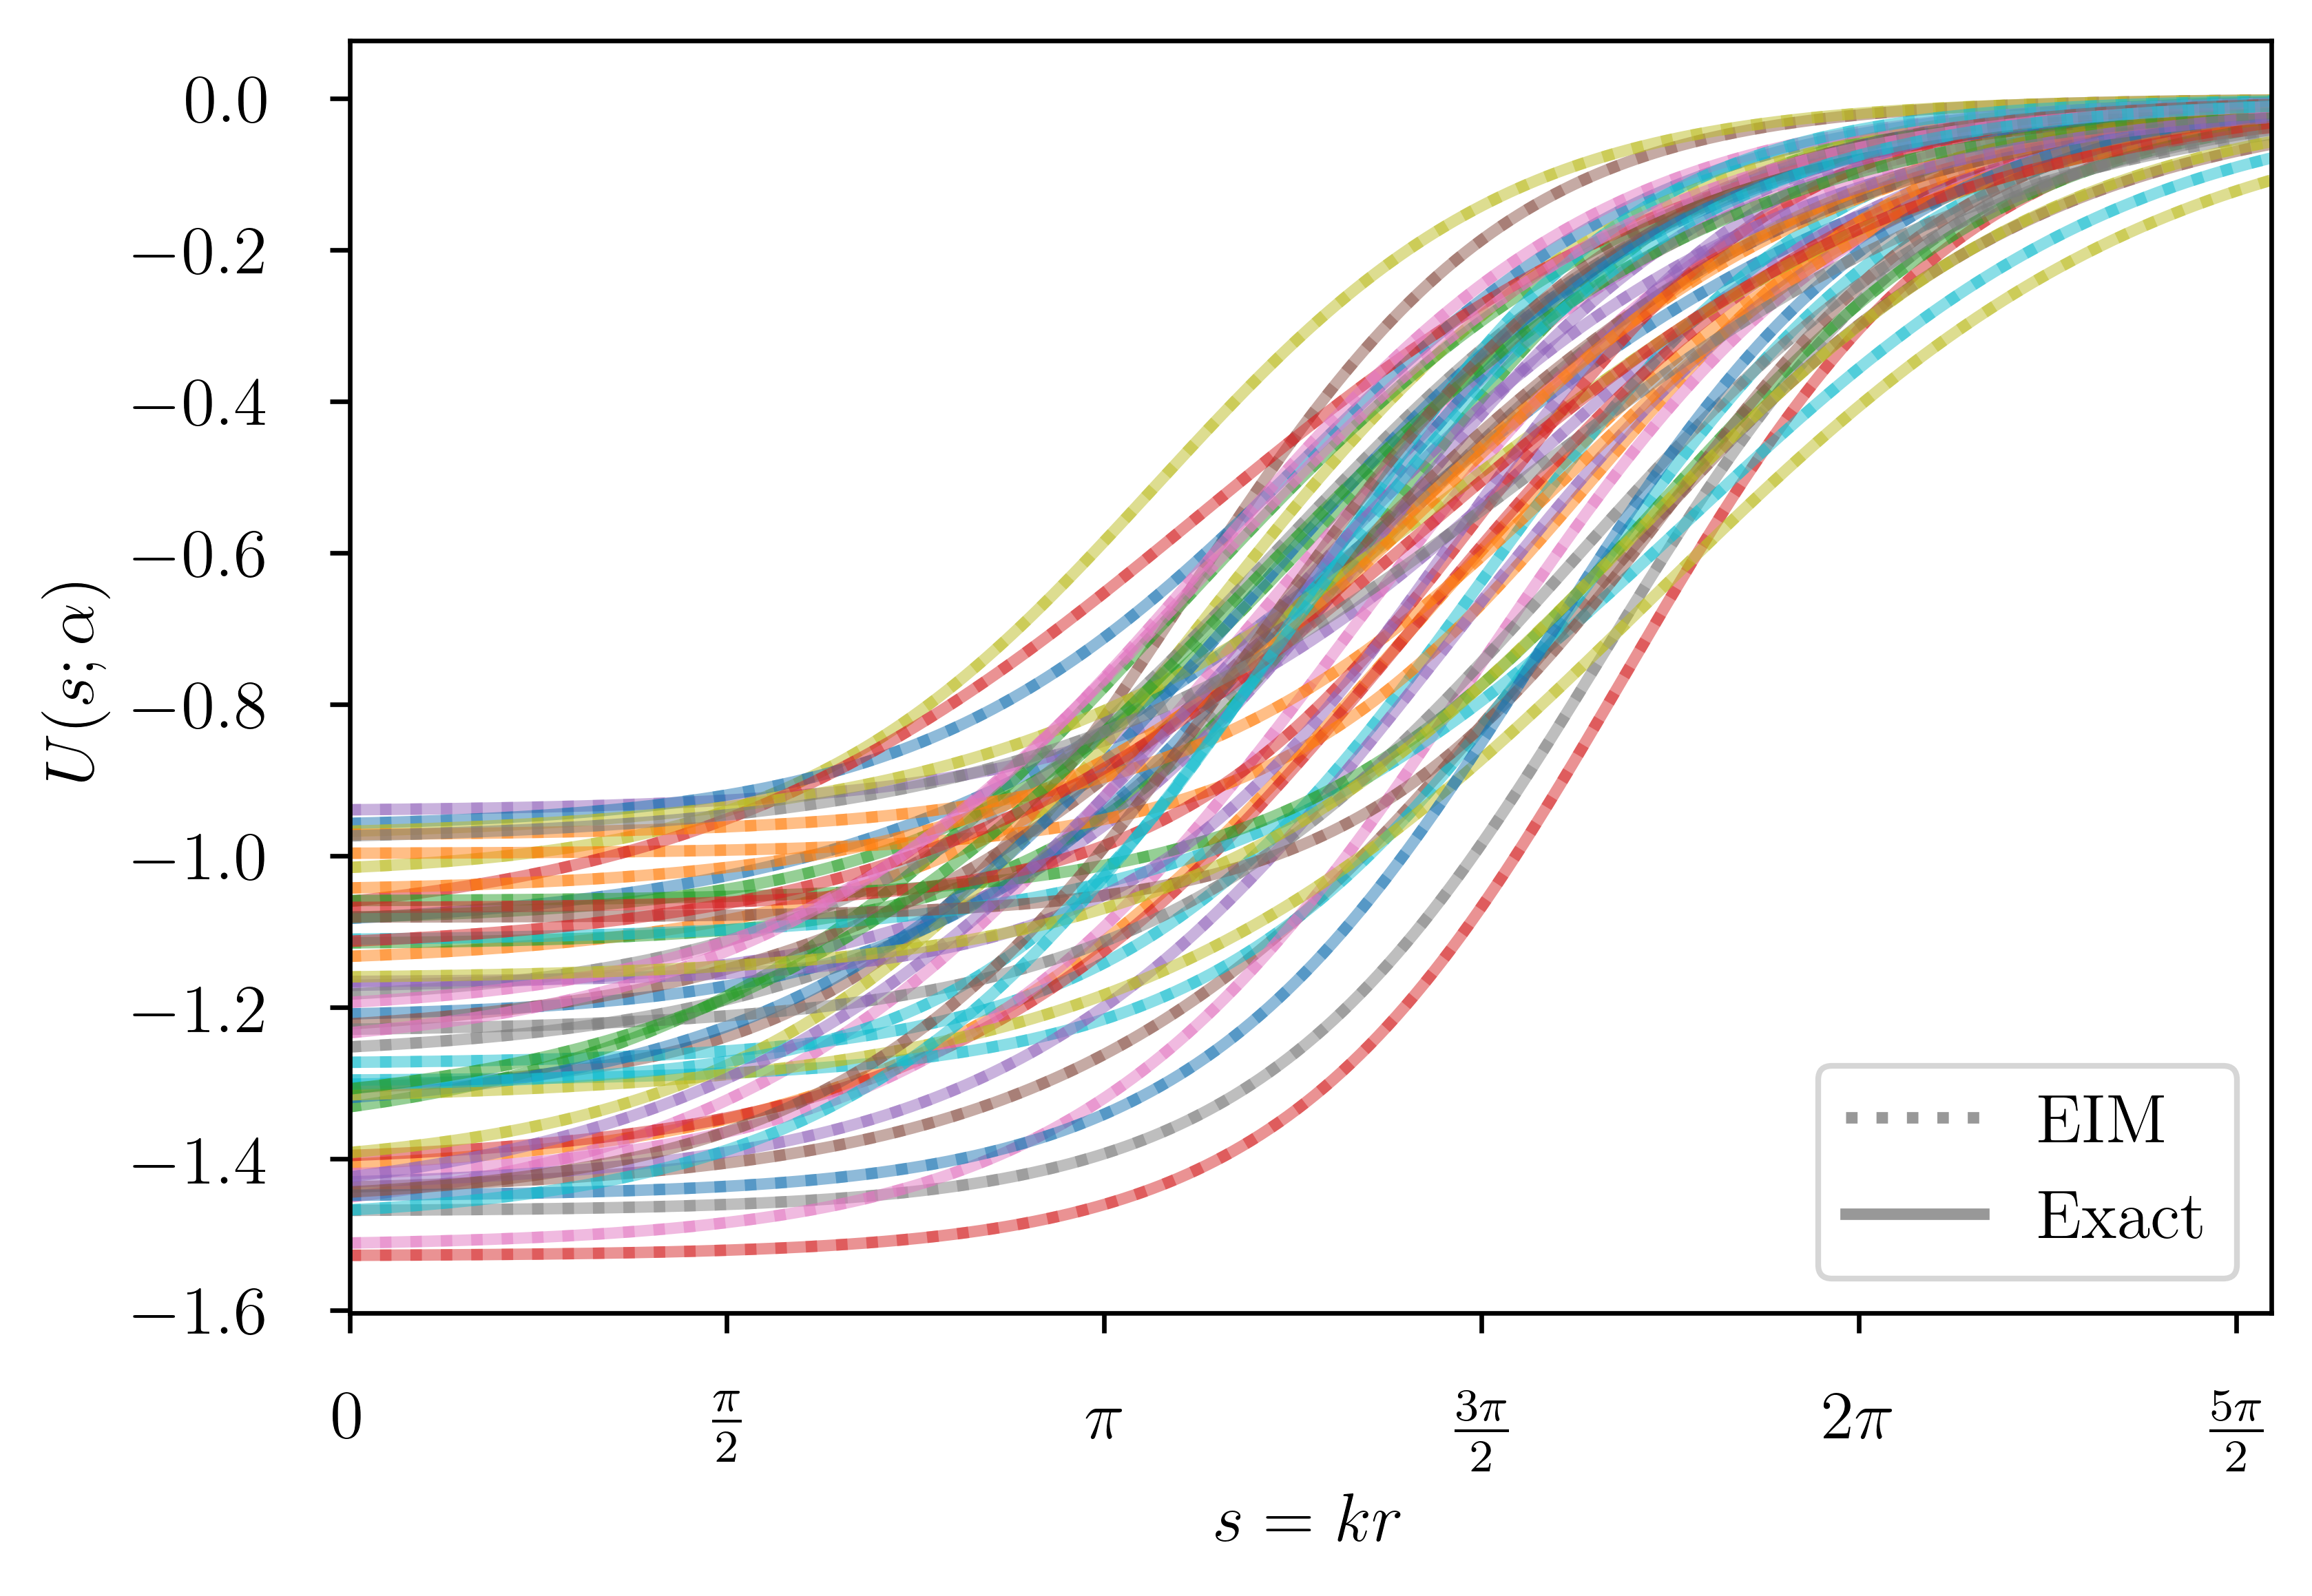

In [10]:
from matplotlib.lines import Line2D

f, ax = plt.subplots(1,1, figsize=(6,4), facecolor="white", dpi=600)

for sample in test_samples[::2]:
    p = plt.plot(s_mesh, emu.rbes[0][0].interaction.tilde(s_mesh, sample), alpha=0.5)[0]
    plt.plot(
        s_mesh,
        emu.rbes[0][0].interaction.tilde_emu(sample),
        ":",
        alpha=0.5,
        color=p.get_color(),
    )
legend_styles = [
    Line2D([0], [0], color="tab:gray", linestyle=":", alpha=0.8),
    Line2D([0], [0], color="tab:gray", alpha=0.8),
]
leg = plt.legend(
    legend_styles,
    ["EIM", "Exact",],
    loc="lower right",
)
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi/2))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter(denominator=2)))
plt.ylabel(r"$U(s; \alpha)$")
plt.xlabel(r"$s = kr$")
plt.xlim([0,8])

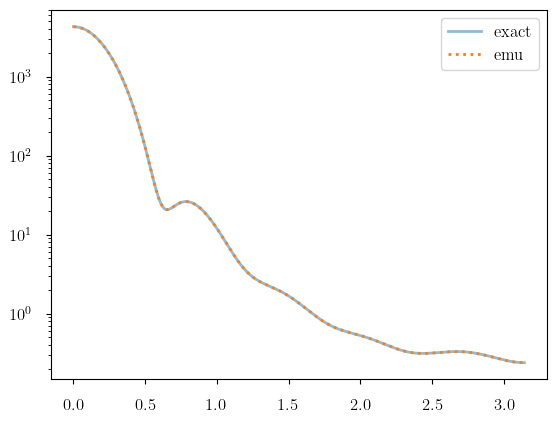

In [11]:
plt.plot(angles, emu.exact_dsdo(test_samples[4]), alpha=0.5, label="exact")
plt.plot(angles, emu.emulate_dsdo(test_samples[4]), ":", label="emu")
#plt.plot(angles, ground_truth_output[4], ":", label="gto")
plt.yscale("log")
plt.legend()

In [12]:
llrm_solver = rose.LagrangeRmatrix(
    interactions.interactions[0][0],
    s_0,
    jitr.RMatrixSolver(100),
)

llrm = rose.ScatteringAmplitudeEmulator.HIFI_solver(
            interactions,
            base_solver=llrm_solver,
            angles=angles,
            s_mesh=s_mesh,
)

In [13]:
# choose the highest fidelity Runge-Kutta solver as our 'ground truth'
rk_domain = [domain[0], domain[1] + np.pi]  # extend rk domain past s_0
hifi_solver = rose.SchroedingerEquation.make_base_solver(
        rk_tols=[1e-11, 1e-11], s_0=s_0, domain=rk_domain
)
ground_truth = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    interactions,
    base_solver=hifi_solver,
    angles=angles,
    s_mesh=s_mesh,
)

And that's it, we have our high-fidelity Lagrange-Legendre R-matrix solver and a Runge-Kutta solver. Let's compare them. 

In [14]:
llrm_solver.im.local_args[0,0] = parameters
llrm_solver.im.local_args[0,0]

array([41.61179081,  3.5063    ,  0.6737851 ,  3.22679339,  3.5063    ,
        0.6737851 ,  5.49425155,  3.88455   ,  0.5401288 ,  5.02807799,
        2.9092    ,  0.59      , -0.22077443,  2.9092    ,  0.59      ])

In [15]:
solutions_llrm = llrm.exact_wave_functions(parameters)

/home/kyle/umich/jitr/src/jitr/rmatrix.py:46: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(complex128, 1, 'C', False, aligned=True), Array(complex128, 2, 'A', False, aligned=True))
  R, Ainv = rmatrix_with_inverse(A, b, nchannels, nbasis, a)


In [16]:
solutions_rk = ground_truth.exact_wave_functions(parameters)

First, let's compare partial waves without phase matching:

(<Figure size 2700x1200 with 2 Axes>,
 <AxesSubplot: xlabel='$s = kr$ [dimensionless]', ylabel='$\\mathfrak{Re} \\, u_{lj}(s)$ [a.u.]'>,
 <AxesSubplot: xlabel='$s = kr$ [dimensionless]', ylabel='$\\mathfrak{Im} \\, u_{lj}(s)$ [a.u.]'>)

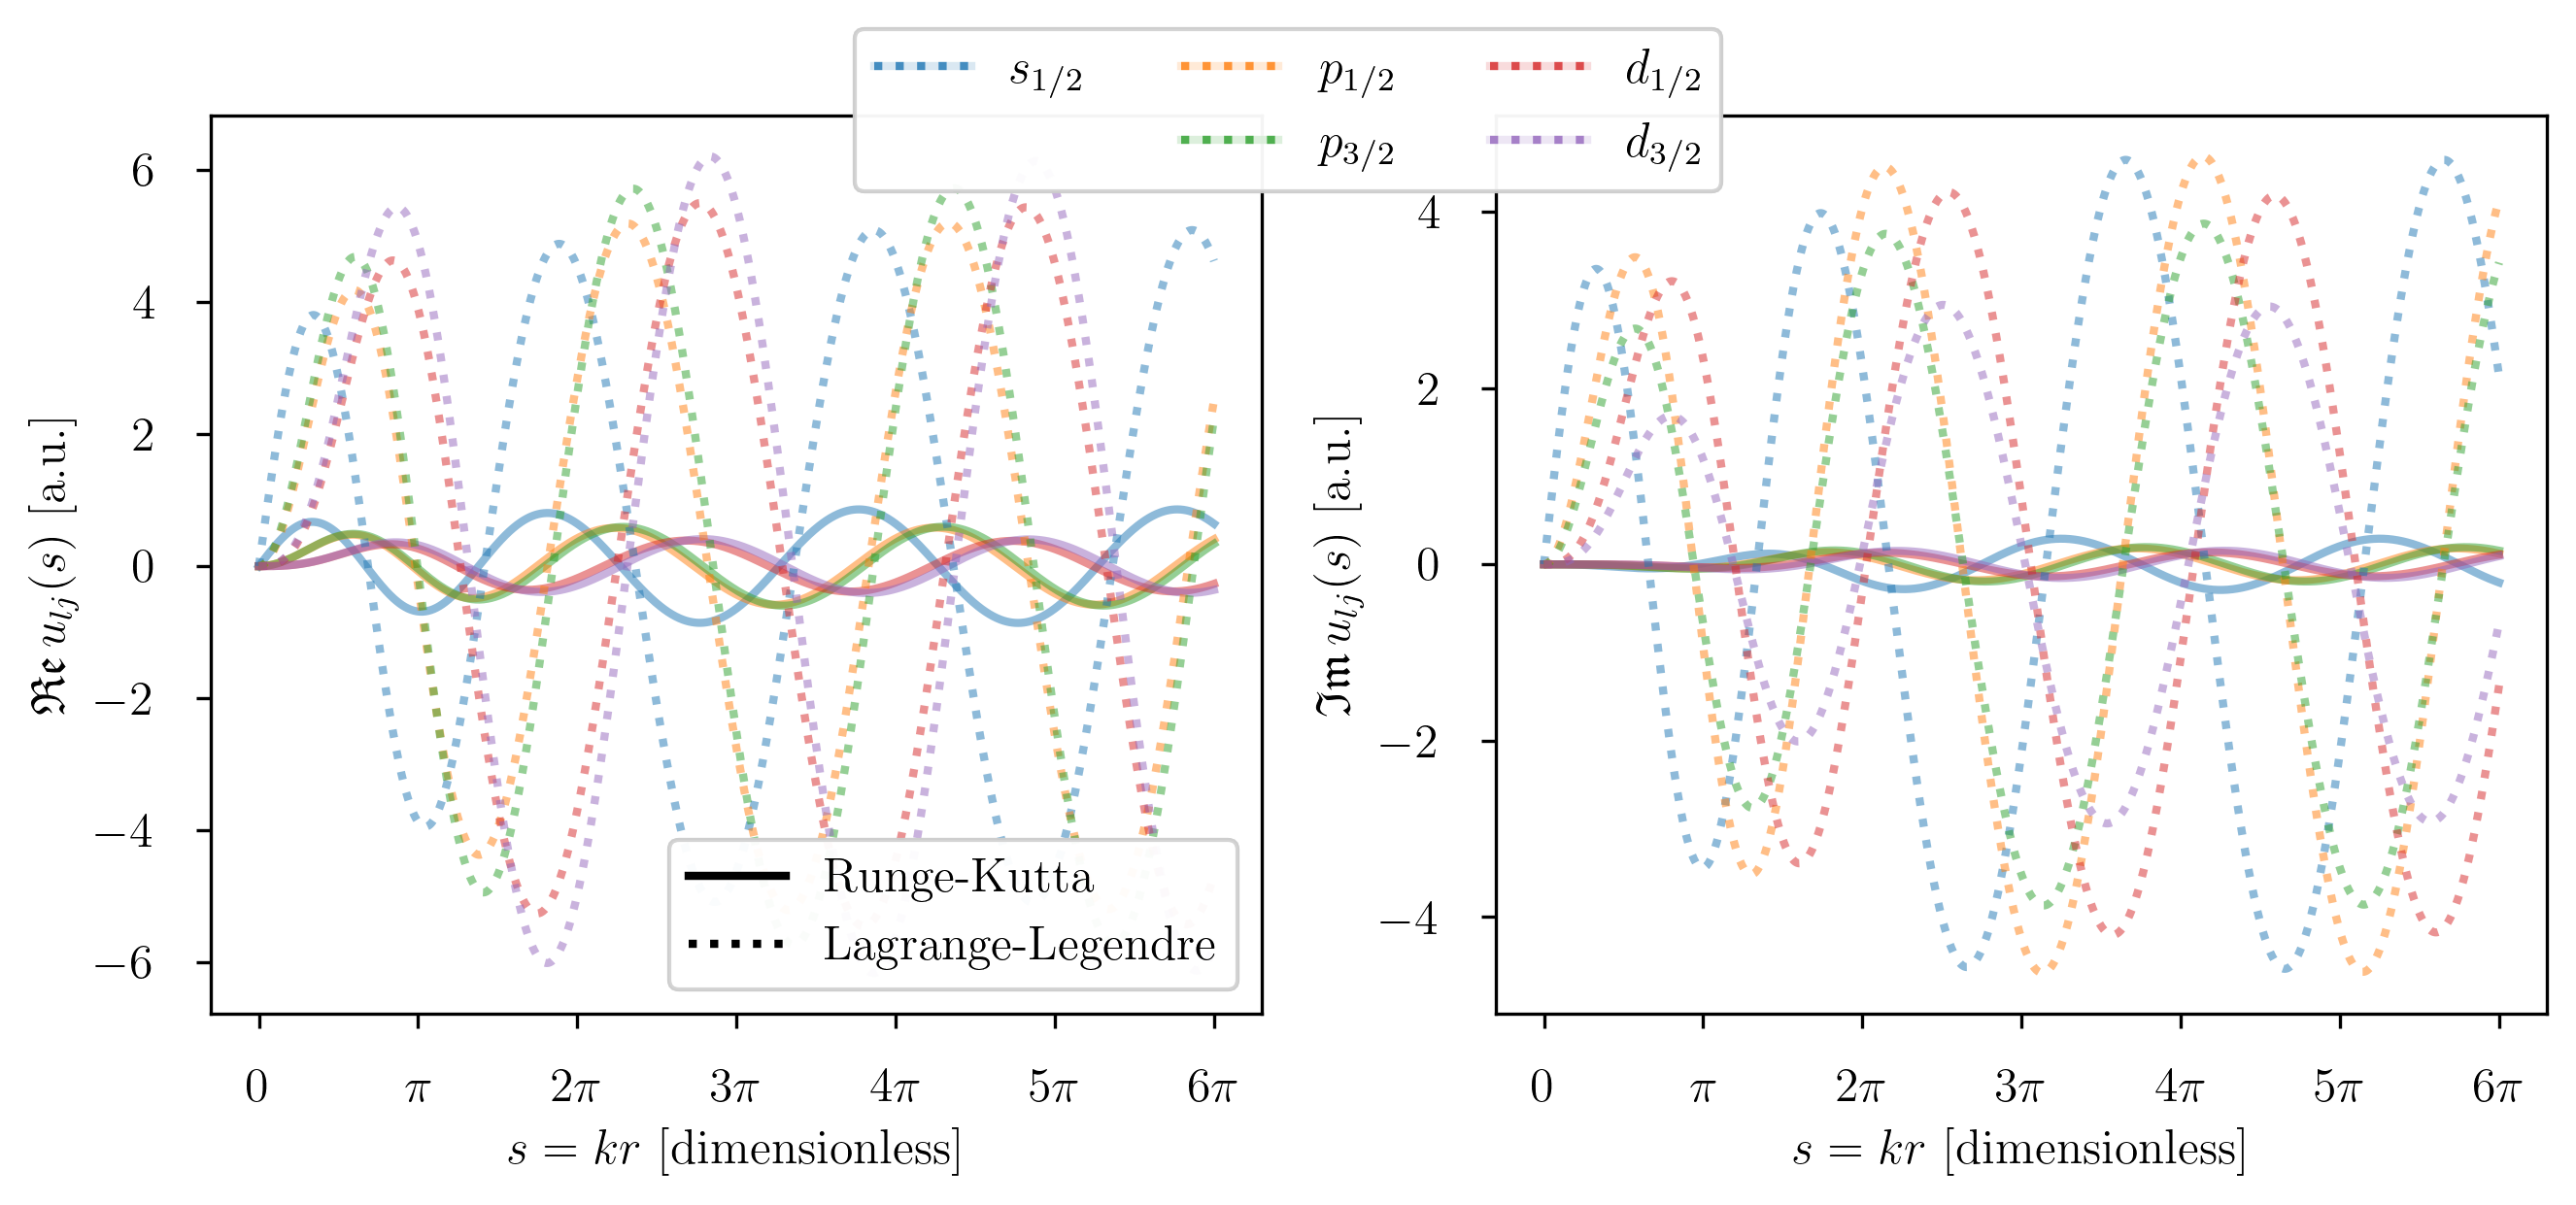

In [17]:
from rose.training import compare_partial_waves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=300)
fig.patch.set_facecolor("white")

compare_partial_waves(
    s_mesh,
    [solutions_rk[0:3], solutions_llrm[0:3]],
    ["Runge-Kutta", "Lagrange-Legendre"],
    fig,
    ax1,
    ax2,
)

Now, let's match phases and look again:

(<Figure size 2700x1200 with 2 Axes>,
 <AxesSubplot: xlabel='$s = kr$ [dimensionless]', ylabel='$\\mathfrak{Re} \\, u_{lj}(s)$ [a.u.]'>,
 <AxesSubplot: xlabel='$s = kr$ [dimensionless]', ylabel='$\\mathfrak{Im} \\, u_{lj}(s)$ [a.u.]'>)

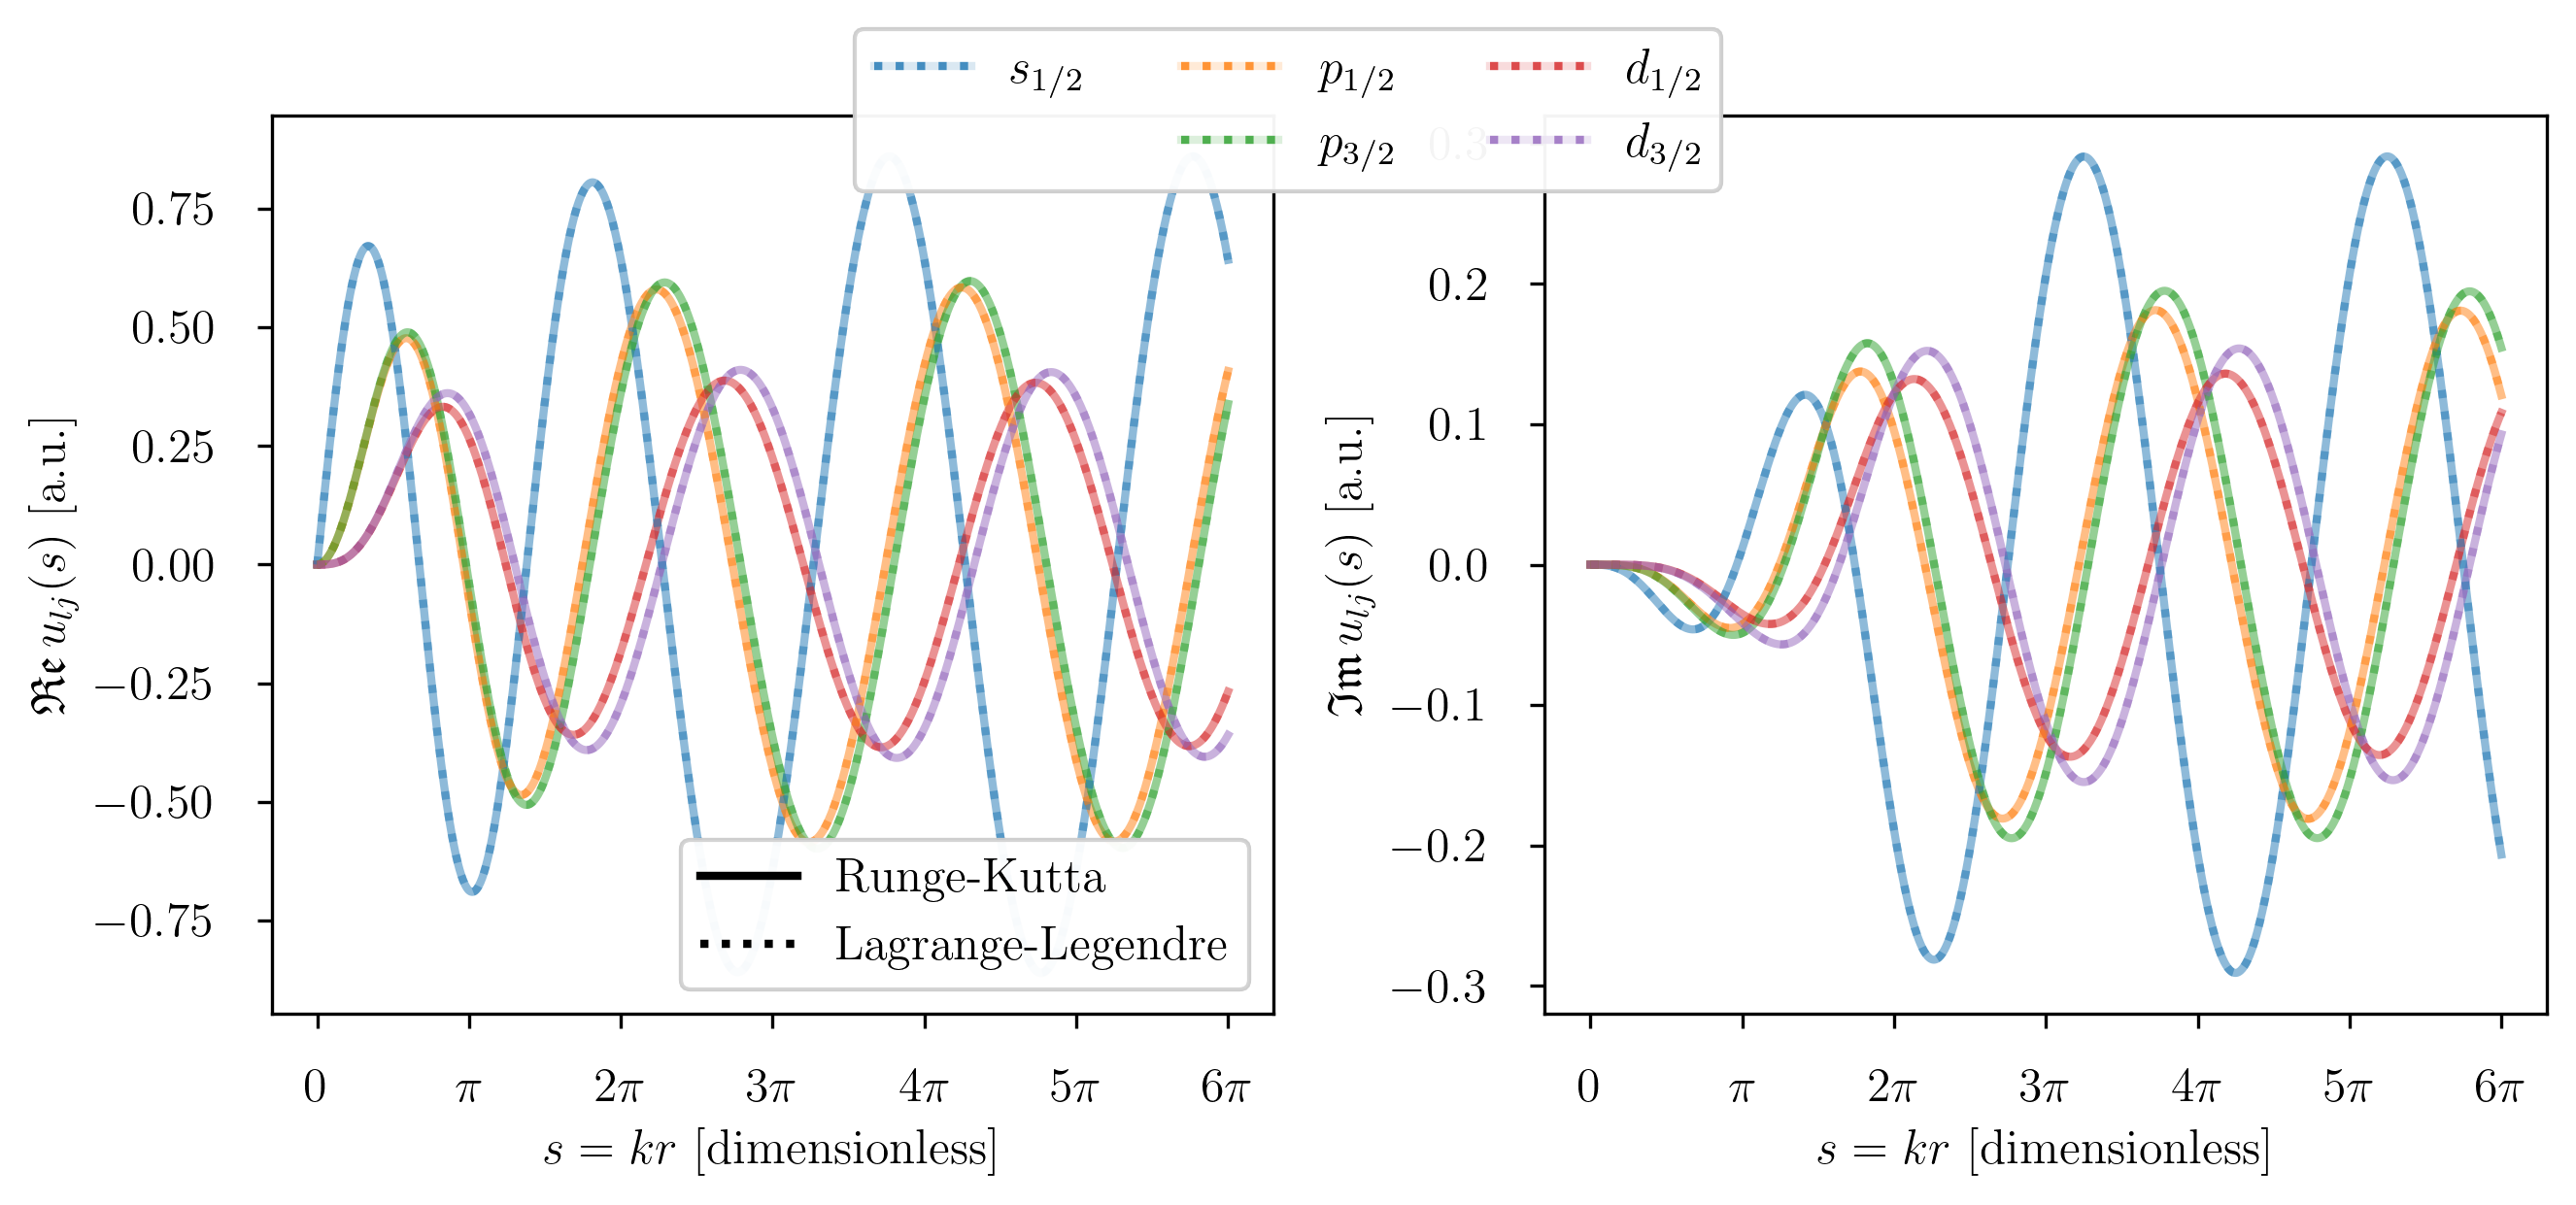

In [18]:
#TODO wavefunction normalization convention
for l in range(len(solutions_rk)):
    for j in range(len(solutions_rk[l])):
        i = 20
        solutions_llrm[l][j] *= (
            solutions_rk[l][j][i] / solutions_llrm[l][j][i])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=300)
fig.patch.set_facecolor("white")

compare_partial_waves(
    s_mesh,
    [solutions_rk[0:3], solutions_llrm[0:3]],
    ["Runge-Kutta", "Lagrange-Legendre"],
    fig,
    ax1,
    ax2,
)

Now, let's take a look at phase shifts:

In [19]:
deltas_rk = ground_truth.exact_phase_shifts(parameters)

In [20]:
deltas_llrm = llrm.exact_phase_shifts(parameters)

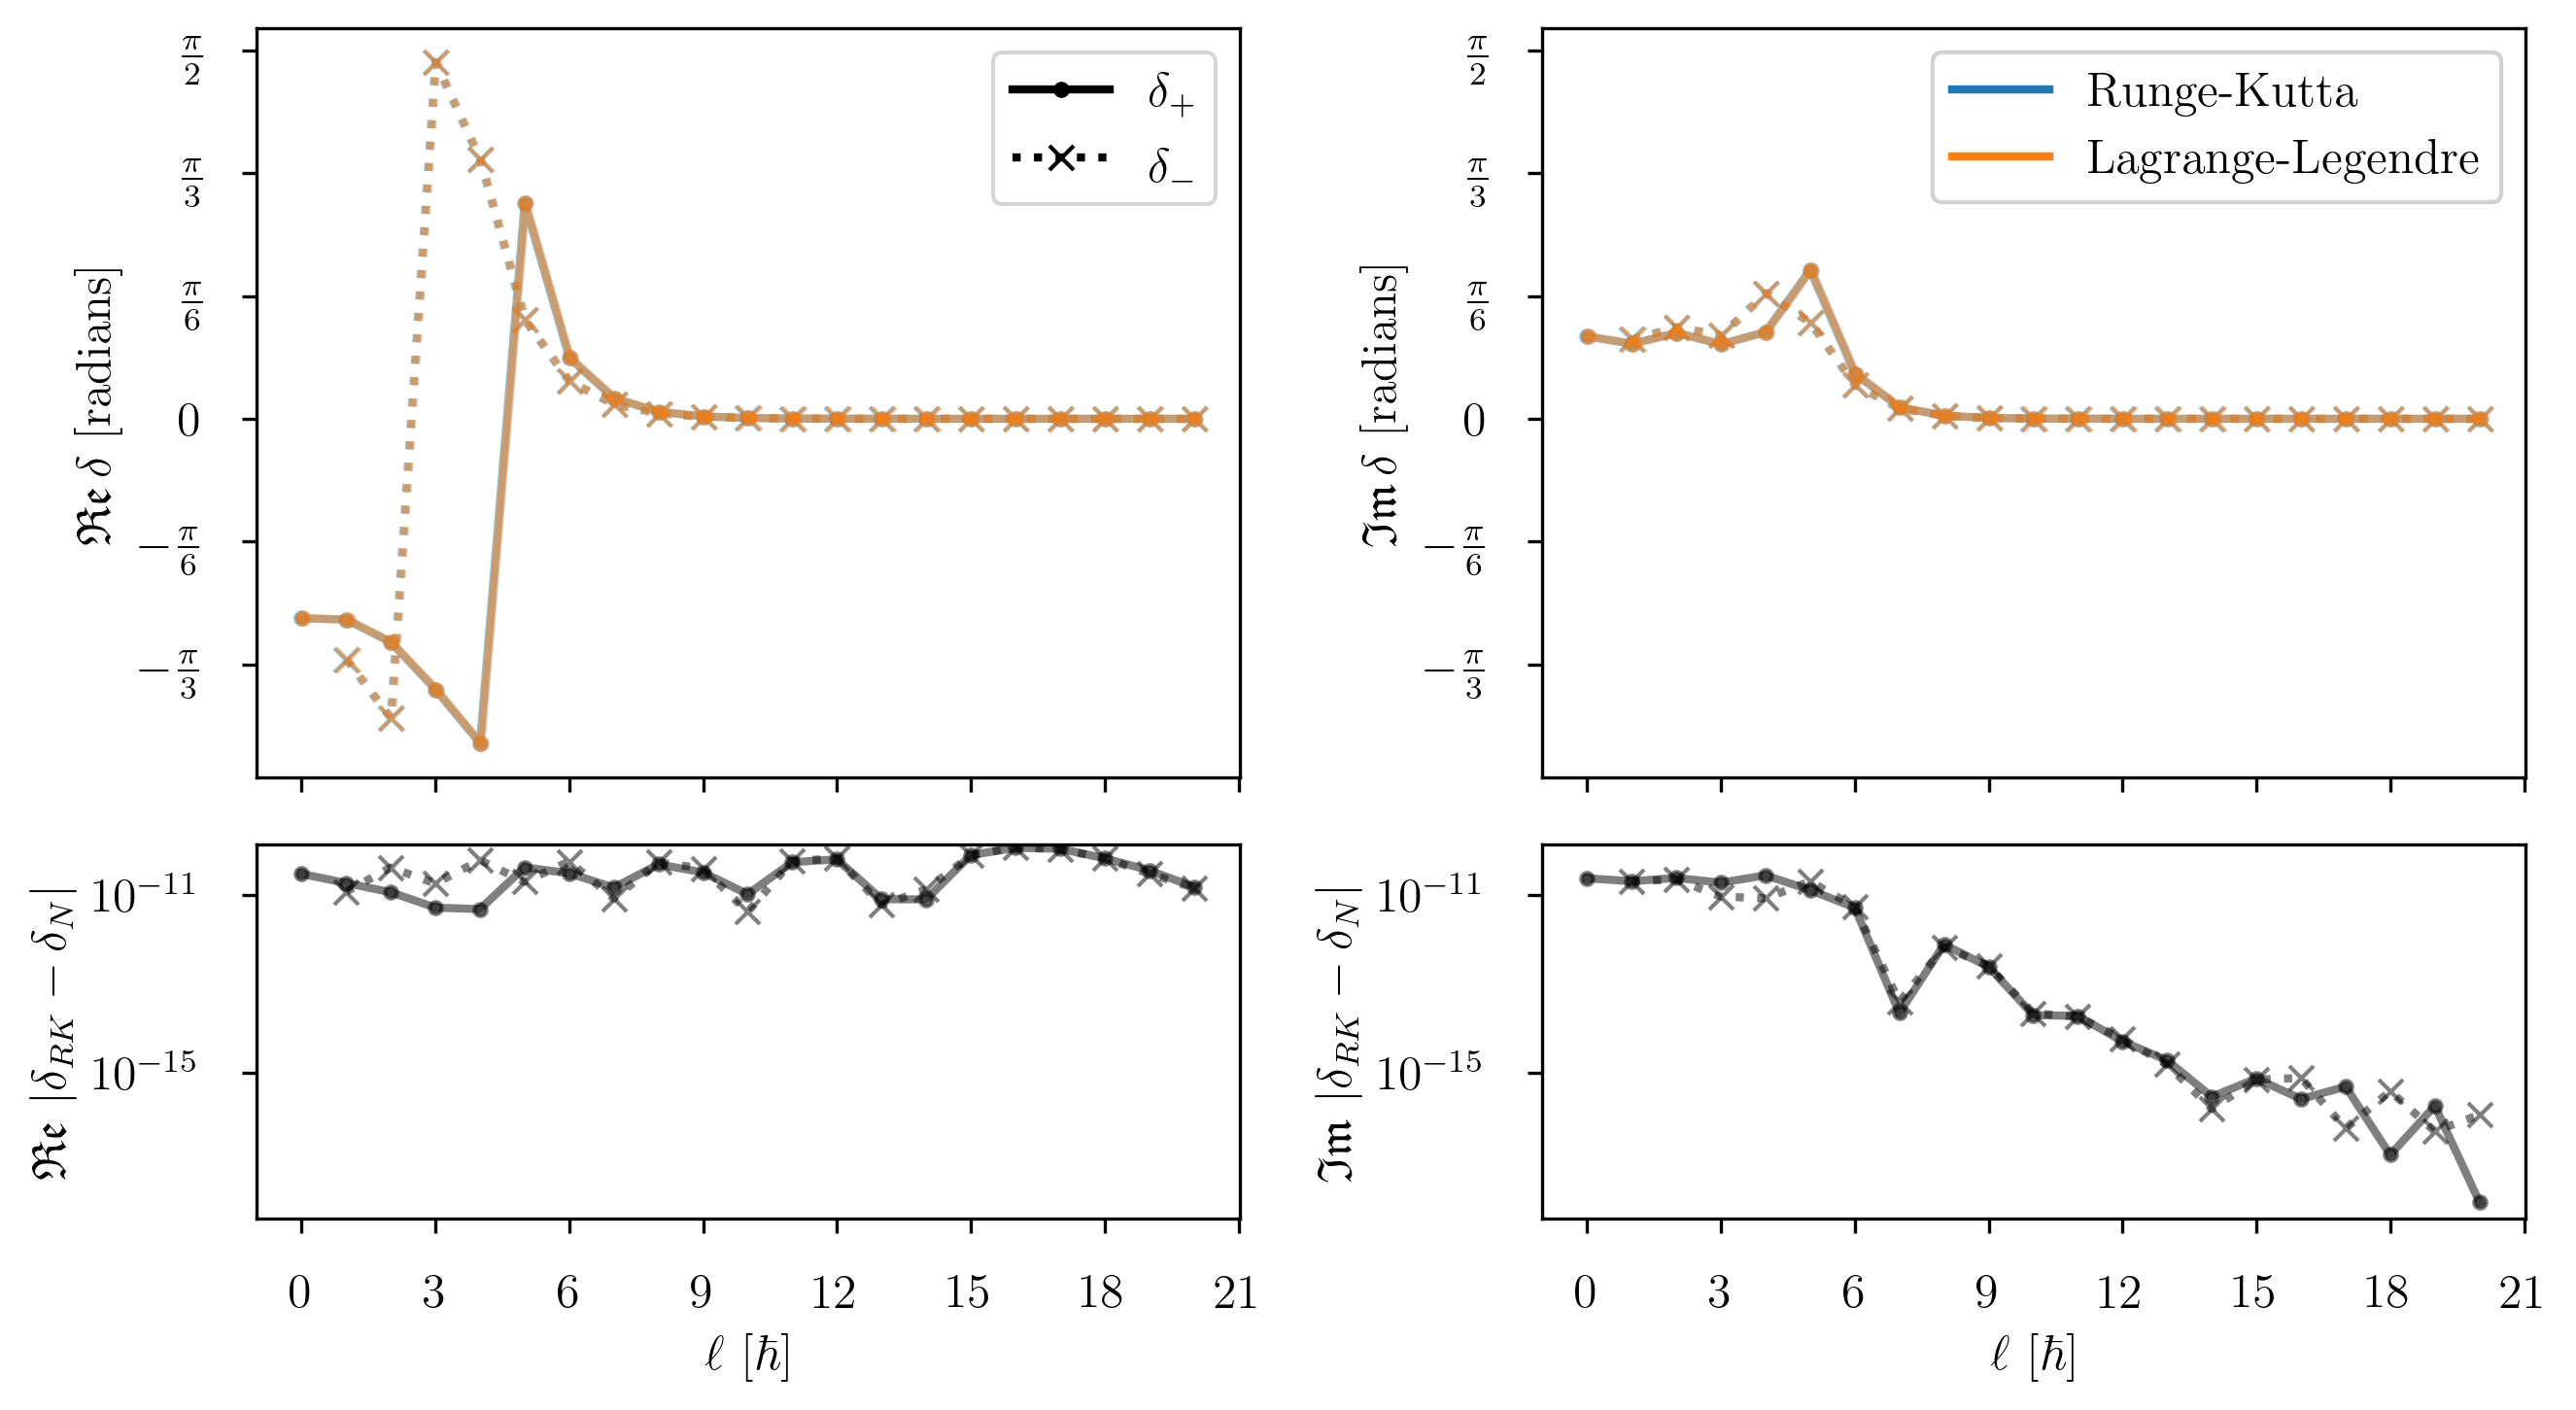

In [21]:
from rose.training import plot_phase_shifts, compare_phase_shifts_err
from matplotlib import ticker

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, sharex=True, figsize=(9, 5), height_ratios=[1, 0.5], dpi=300
)
fig.patch.set_facecolor("white")

compare_phase_shifts_err(
    deltas_rk,
    deltas_llrm,
    "Runge-Kutta",
    "Lagrange-Legendre",
    fig,
    ax1,
    ax2,
    ax3,
    ax4,
    small_label1="RK",
    small_label2="N",
)

plt.tight_layout()

In [22]:
rk_tolerances = [(1e-5, 1e-5), (1e-7, 1e-7), (1e-9, 1e-9)]
rk_solvers = []

for rk_tols in rk_tolerances:
    solver = rose.SchroedingerEquation.make_base_solver(
        rk_tols=rk_tols, s_0=s_0, domain=rk_domain
    )
    rk_solvers.append(
        rose.ScatteringAmplitudeEmulator.HIFI_solver(
            interactions, base_solver=solver, angles=angles, s_mesh=s_mesh
        )
    )

In [23]:
nbases = [30, 50, 70]
llrm_solvers = []
for n in nbases:
    solver = rose.LagrangeRmatrix(
        interactions.interactions[0][0],
        s_0,
        jitr.RMatrixSolver(n)
    )

    llrm_solvers.append(
        rose.ScatteringAmplitudeEmulator.HIFI_solver(
            interactions,
            base_solver=solver,
            angles=angles,
            s_mesh=s_mesh,
        )
    )


Not bad! How does this translate to cross sections? Let's calculate $d\sigma/d\Omega$ for various instances of our interaction with different parameters.

In [24]:
%%time
# calculate ground truth differential cross sections for each sample
fpath = Path("ground_truth_rm_vs_rk_test.pkl")

if fpath.is_file():
    with open(fpath, 'rb') as f:
        ground_truth_output = pickle.load(f)
else:
    ground_truth_output = []
    for sample in tqdm(test_samples):
        ground_truth_output.append(ground_truth.exact_xs(sample).dsdo)
    with open(fpath, 'wb') as f:
        pickle.dump(ground_truth_output, f)

CPU times: user 1.04 ms, sys: 376 µs, total: 1.41 ms
Wall time: 1.06 ms


In [25]:
%%time
# calculate lowfi differential cross sections for each sample to compare
lowfi_solver = llrm_solvers[1]
lowfi_method = "Lagrange-Legendre n={}".format(nbases[1])

lowfi_output = []
for sample in tqdm(test_samples):
    lowfi_output.append(lowfi_solver.exact_xs(sample).dsdo)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 65.78it/s]

CPU times: user 1.52 s, sys: 2.16 ms, total: 1.52 s
Wall time: 1.52 s


Text(0.5, 0, '$\\theta$ [radians]')

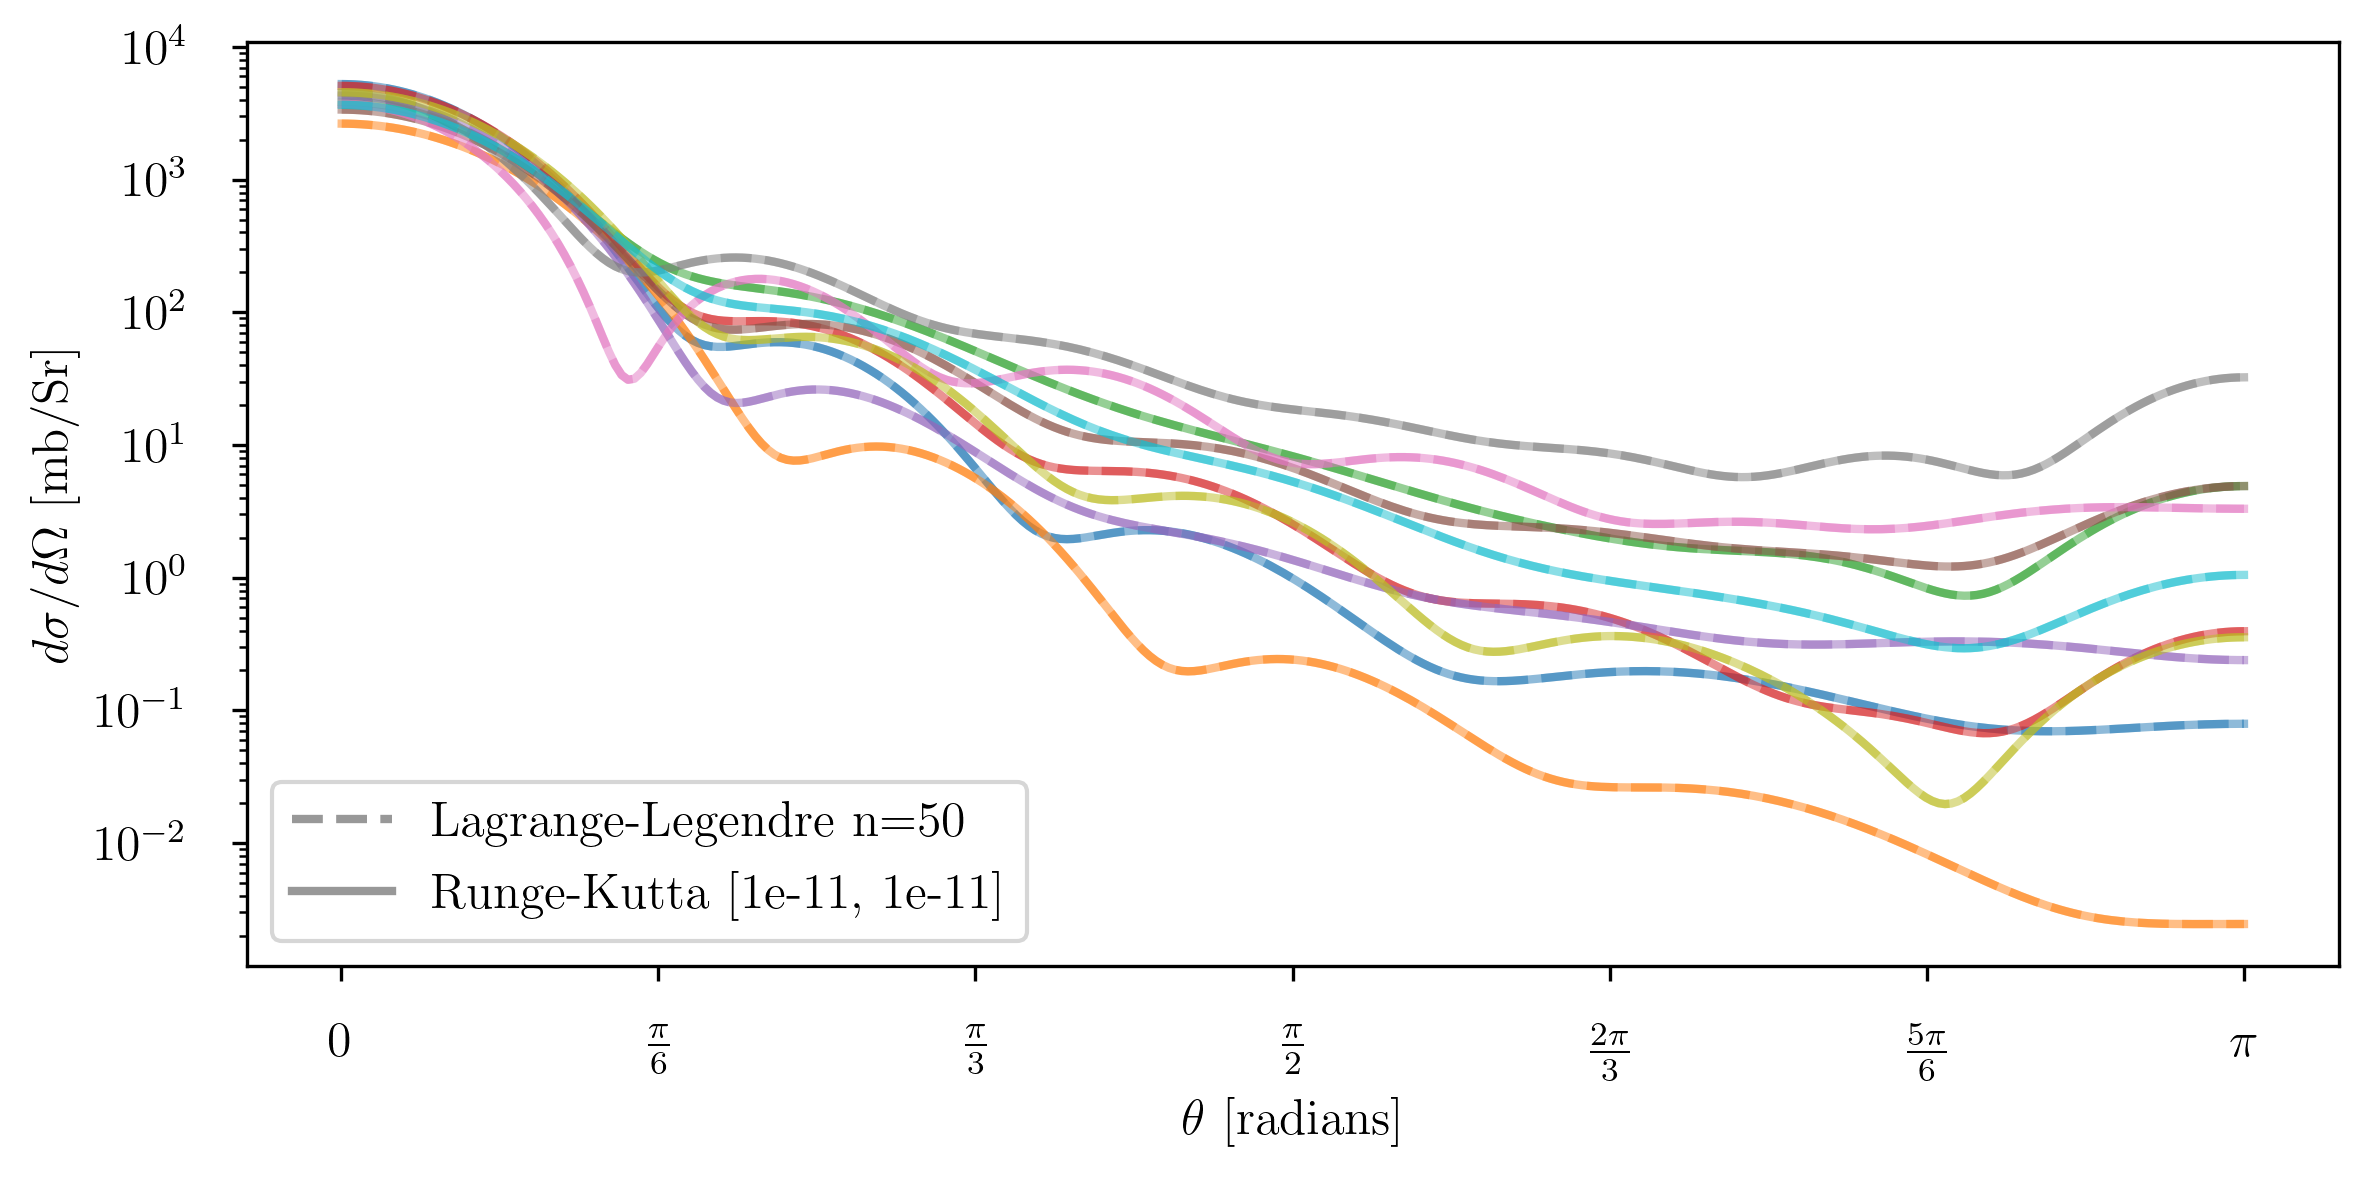

In [26]:
from matplotlib.lines import Line2D
from rose.training import multiple_formatter
fig, ax = plt.subplots(figsize=(9, 4), dpi=300)
fig.patch.set_facecolor("white")

# only plot a few
n2plot = 10
for xs_hifi, xs_lowfi in zip(ground_truth_output[:n2plot], lowfi_output[:n2plot]):
    p = ax.plot(angles, xs_hifi, alpha=0.5)[0]
    ax.plot(angles, xs_lowfi, "--", color=p.get_color(), alpha=0.5)

legend_styles = [
    Line2D([0], [0], color="tab:gray", linestyle="--", alpha=0.8),
    Line2D([0], [0], color="tab:gray", alpha=0.8),
]
leg = plt.legend(
    legend_styles,
    [lowfi_method, "Runge-Kutta [1e-11, 1e-11]",],
    loc="lower left",
)

ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi/6))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter(denominator=6)))
ax.set_yscale("log")
ax.set_ylabel(r"$ d \sigma / d\Omega $ [mb/Sr]")
ax.set_xlabel(r"$\theta$ [radians]")

Looks like $n=50$ is pretty darn good, but it does have a few cases with minor disagreements to the high fidelity. Let's quantify this with a CAT plot:

In [27]:
from rose.training import CATPerformance

In [28]:
%%time
rk_solver_performances = []
for solver, tols in zip(rk_solvers, rk_tolerances):
    label = r"$\left[{:1.0e} , {:1.0e}\right]$".format(*tols)
    fpath = Path("perf_rk_{:1.0e}_{:1.0e}.pkl".format(*tols))
    if fpath.is_file():
        with open(fpath, 'rb') as f:
            perf = pickle.load(f)
            rk_solver_performances.append(perf)
    else:
        rk_solver_performances.append(
            CATPerformance(
                benchmark_runner=lambda sample: solver.exact_xs(sample).dsdo,
                benchmark_inputs=test_samples,
                benchmark_ground_truth=ground_truth_output,
                label=label,
            )
        )
        with open(fpath, 'wb') as f:
            pickle.dump(rk_solver_performances[-1], f)

CPU times: user 0 ns, sys: 1.1 ms, total: 1.1 ms
Wall time: 971 µs


In [29]:
%%time
llrm_solver_performances = []
for solver, n in zip(llrm_solvers, nbases):
    label = r"$N  = {}$".format(n)
    fpath = Path("perf_llrm_N_{}.pkl".format(n))
    if fpath.is_file():
        with open(fpath, "rb") as f:
            perf = pickle.load(f)
            llrm_solver_performances.append(perf)
    else:
        llrm_solver_performances.append(
            CATPerformance(
                benchmark_runner=lambda sample: solver.exact_xs(sample).dsdo,
                benchmark_inputs=test_samples,
                benchmark_ground_truth=ground_truth_output,
                label=label,
            )
        )
        with open(fpath, "wb") as f:
            pickle.dump(llrm_solver_performances[-1], f)

CPU times: user 1.44 ms, sys: 520 µs, total: 1.96 ms
Wall time: 1.52 ms


In [31]:
# [basis size, number of terms in EIM decomposition]
sae_configs = [(5, 5), (10, 10), (15, 15), (20, 20)]
_, emulators = rose.training.build_sae_config_set(
    sae_configs,
    interactions,
    training_samples,
    bounds,
    angles=angles,
    base_solver=hifi_solver,
    s_mesh=s_mesh,
    scale=True,
    use_svd=True,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:32<00:00, 38.05s/it]


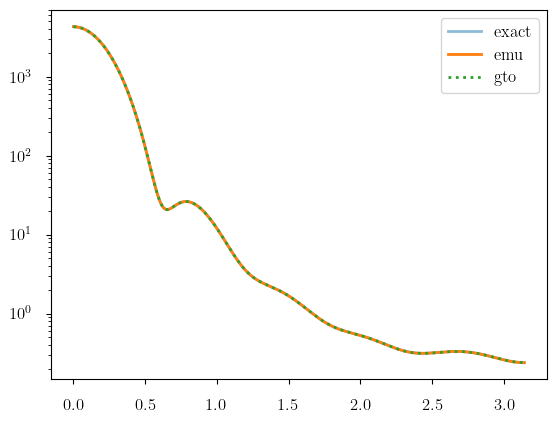

In [32]:
emu = emulators[-1]
plt.plot(angles, emu.exact_dsdo(test_samples[4]), alpha=0.5, label="exact")
plt.plot(angles, emu.emulate_dsdo(test_samples[4]), label="emu")
plt.plot(angles, ground_truth_output[4], ":", label="gto")
plt.yscale("log")
plt.legend()

In [33]:
rbm_performances = []
for solver, config in zip(emulators, sae_configs):
    label = r"$\left({:d} , {:d}\right)$".format(*config)
    fpath = Path("perf_rbm_{:d}_{:d}.pkl".format(*config))
    if fpath.is_file():
        with open(fpath, "rb") as f:
            perf = pickle.load(f)
            rbm_performances.append(perf)
    else:
        rbm_performances.append(
            CATPerformance(
                benchmark_runner=lambda sample: solver.emulate_xs(sample).dsdo,
                benchmark_inputs=test_samples,
                benchmark_ground_truth=ground_truth_output,
                label=label,
            )
        )
        with open(fpath, "wb") as f:
            pickle.dump(rbm_performances[-1], f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 134.86it/s]


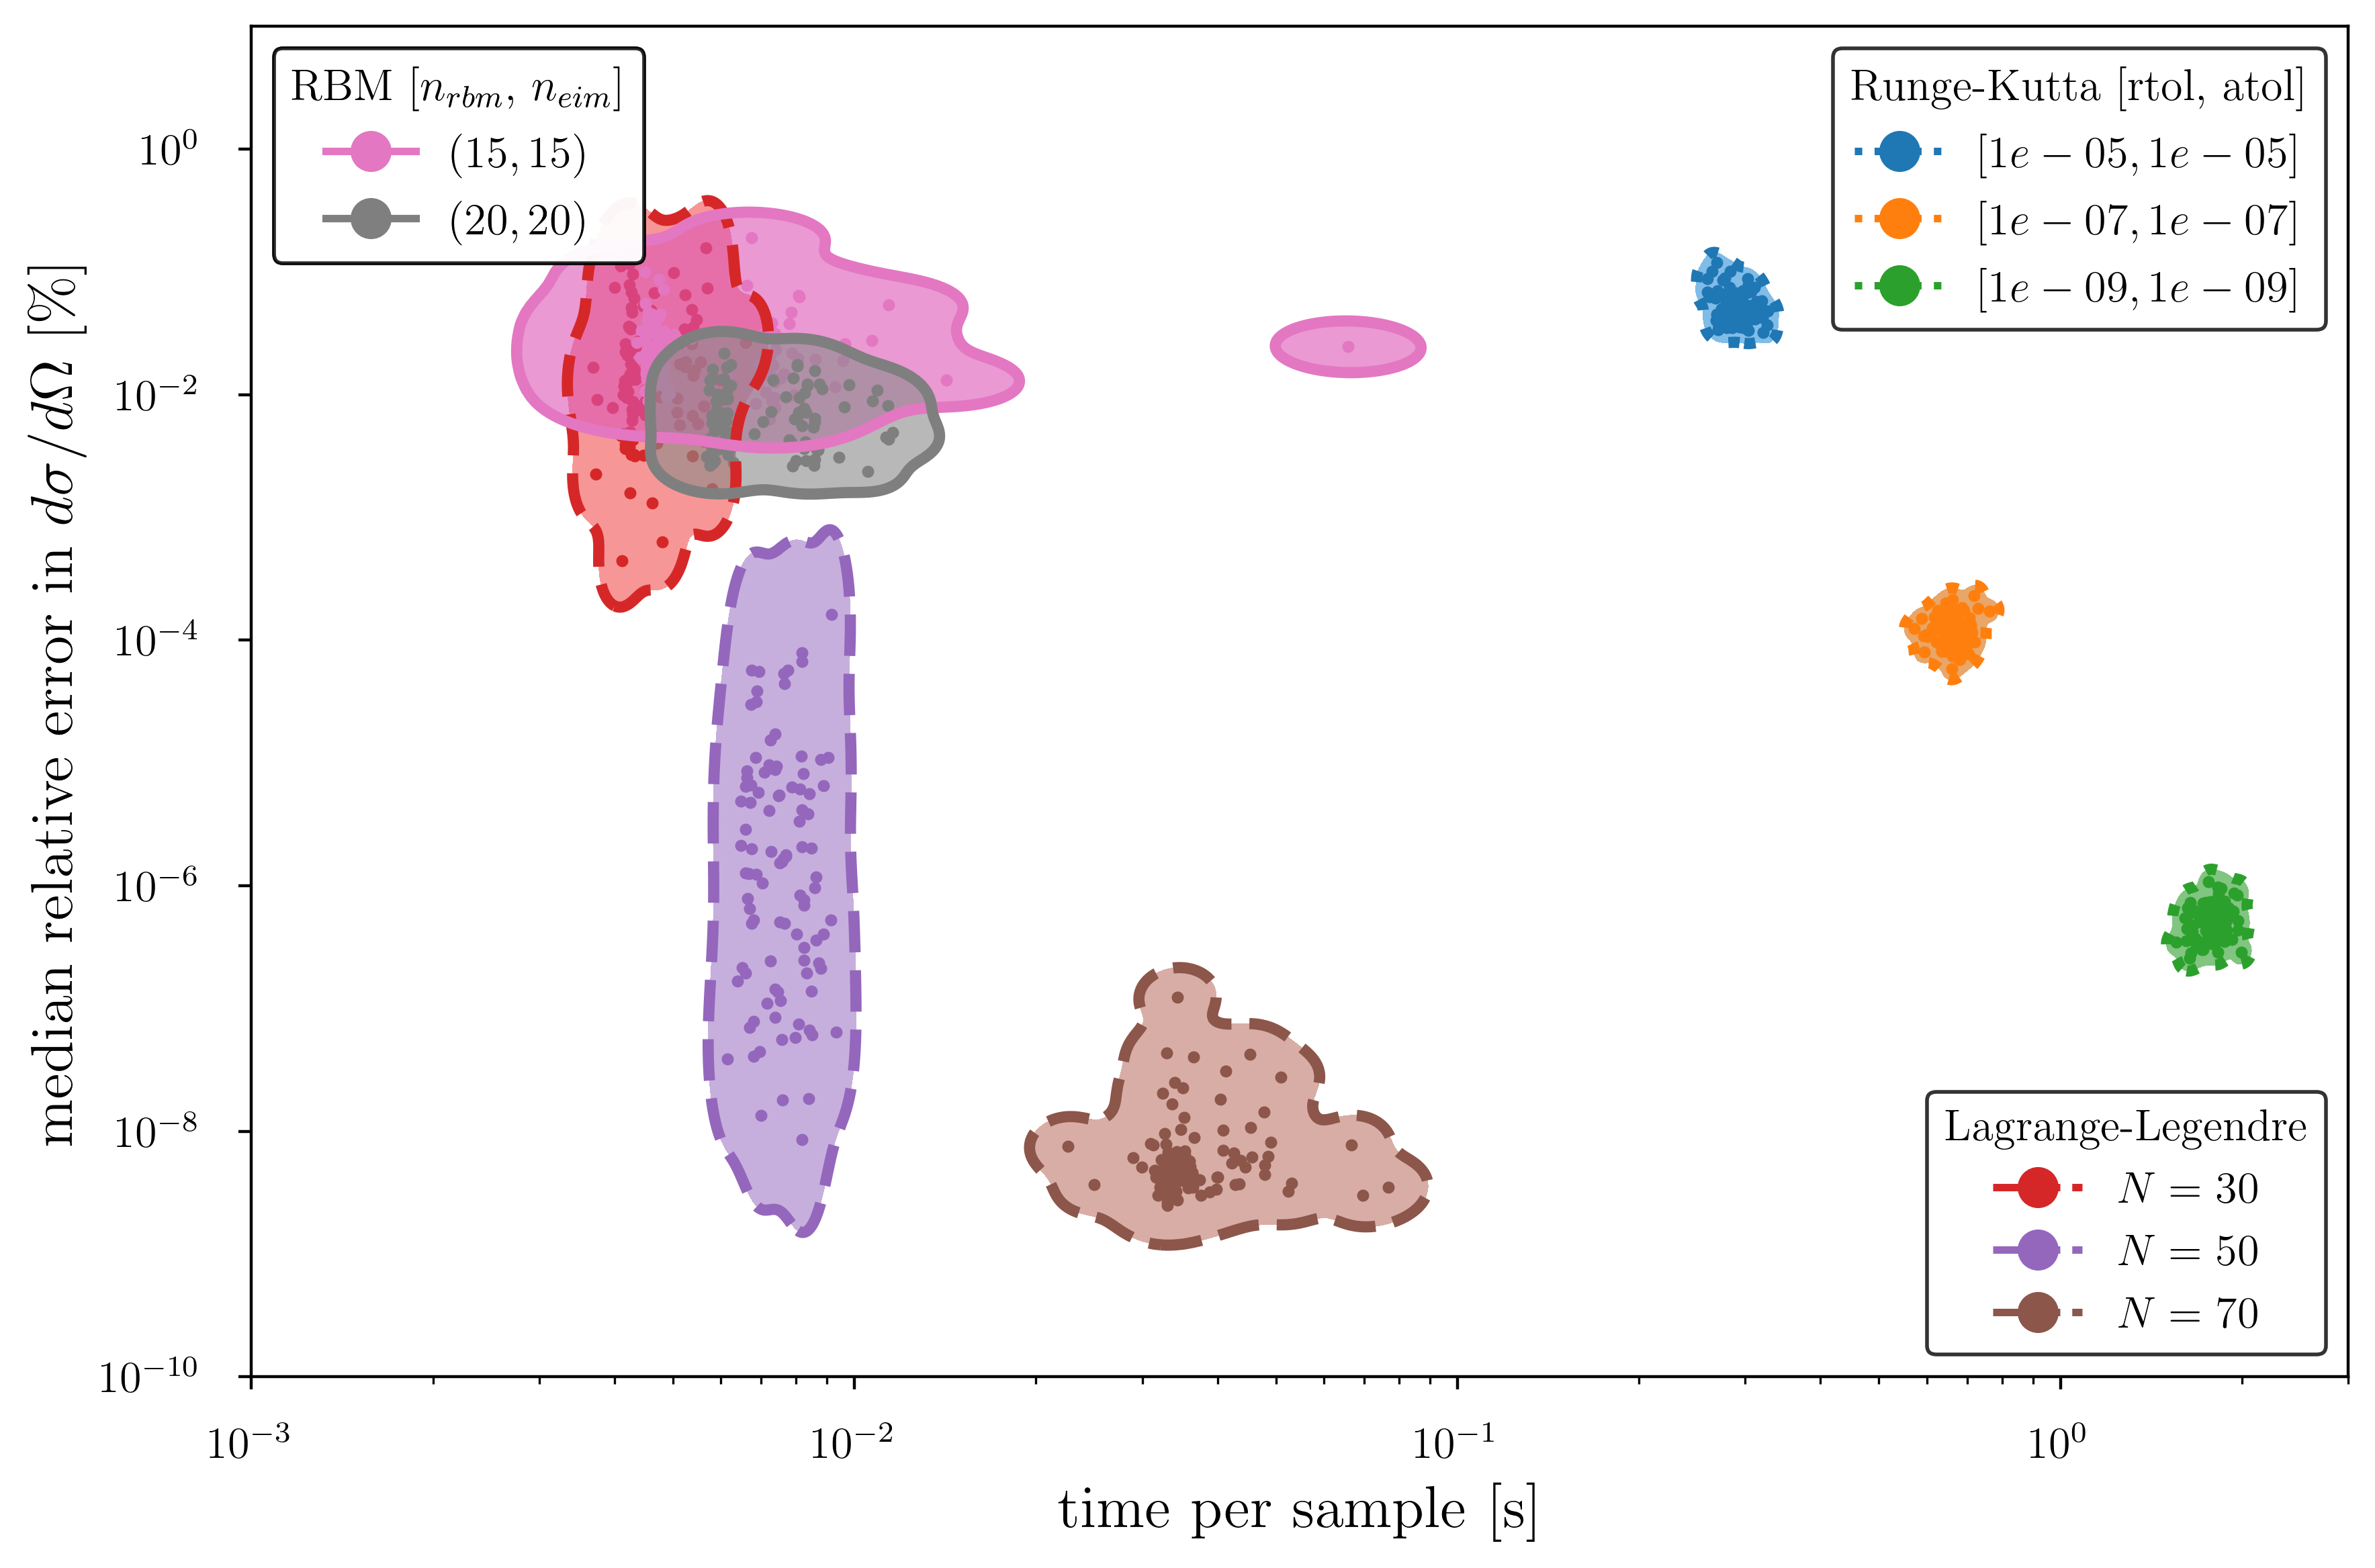

In [53]:
# plot the Computational Accuracy vs. Time (CAT)
from rose.training import CAT_plot

fig, ax = CAT_plot(
    [rk_solver_performances, llrm_solver_performances, rbm_performances[2:]],
    labels=["Runge-Kutta [rtol, atol]", "Lagrange-Legendre", "RBM [$n_{rbm}$, $n_{eim}$]"],
    border_styles=[":", "--", "-"],
)
ax.set_ylabel(r"median relative error in $d \sigma / d \Omega$ [\%]", size=16)
ax.set_xlabel(r"time per sample [s]", size=16)

ax.set_ylim(1e-10,10)
ax.set_xlim(1e-3,3)
plt.tight_layout()
plt.savefig("cat_rbm_rm_rk.pdf")

Great! It looks like using this Lagrange-Legendre method could save us a lot of time in training. For most purposes, $n \sim 100$ should be good, with less than 0.1% median relative error across all samples, and a ~1-1.5 order of magnitude speed up from the Runge-Kutta solvers.

In [ ]:
# plot the Computational Accuracy vs. Time (CAT)
from rose.training import CAT_plot

fig, ax = CAT_plot(
    [rk_solver_performances, llrm_solver_performances],
    labels=["Runge-Kutta [rtol, atol]", "Lagrange-Legendre"],
    border_styles=[":", "-"],
)
ax.set_ylabel(r"median relative error in $d \sigma / d \Omega$ [%]")
ax.set_ylim(1e-10,100)
ax.set_xlim(2e-3,10)